# Backdoor detector and pruning Defence

In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 30.00 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
!cp -r ./drive/MyDrive/Lab3/* ./CSAW-HackML-2020/lab3/data/

In [ ]:
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers

import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def data_loader(filepath):  # from eval.py
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))
    return x_data, y_data

Paths to the data and the models

In [ ]:
bad_model = './CSAW-HackML-2020/lab3/models/bd_net.h5'
bad_model_weights = './CSAW-HackML-2020/lab3/models/bd_weights.h5'

clean_test = './CSAW-HackML-2020/lab3/data/cl/test.h5'
clean_valid = './CSAW-HackML-2020/lab3/data/cl/valid.h5'
poison_test = './CSAW-HackML-2020/lab3/data/bd/bd_test.h5'
poison_valid = './CSAW-HackML-2020/lab3/data/bd/bd_valid.h5'

x_clean_test, y_clean_test = data_loader(clean_test)
x_clean_valid, y_clean_valid = data_loader(clean_valid)
x_poison_test, y_poison_test = data_loader(poison_test)
x_poison_valid, y_poison_valid = data_loader(poison_valid)


Plotting some test images.

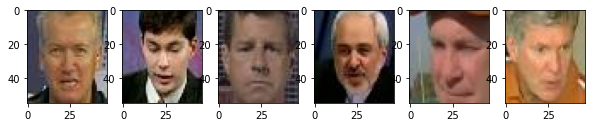

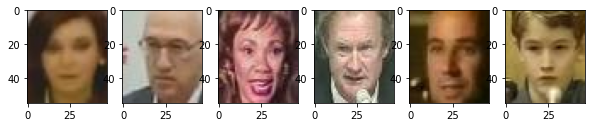

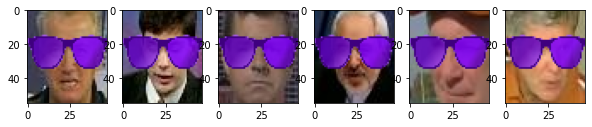

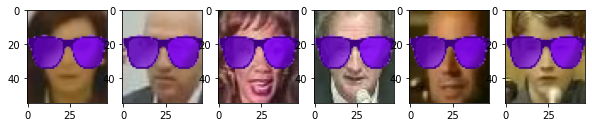

In [ ]:
plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_clean_test[id]/255)  

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_clean_valid[id]/255) 

plt.figure(figsize=(10,3))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_poison_test[id]/255) 

plt.figure(figsize=(10,2))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_poison_valid[id]/255)

Checking the accuracy on the clean and poison data before pruning 

In [ ]:
def check_acc(model,x,y):
  label = np.argmax(model.predict(x), axis=1)
  acc = np.mean(np.equal(label,y))*100
  return acc

In [ ]:
badnet = keras.models.load_model(bad_model)
print("Bad net accuracy for clean validation images: ",check_acc(badnet,x_clean_valid,y_clean_valid))
print("Bad net accuracy for clean test images: ",check_acc(badnet,x_clean_test,y_clean_test))
print("Bad net accuracy for poison validation images: ",check_acc(badnet,x_poison_valid,y_poison_valid))
print("Bad net accuracy for poison test images: ",check_acc(badnet,x_poison_test,y_poison_test))

Bad net accuracy for clean validation images:  98.64899974019225
Bad net accuracy for clean test images:  98.62042088854248
Bad net accuracy for poison validation images:  100.0
Bad net accuracy for poison test images:  100.0


## Pruning the badnet model

In [ ]:
def pruner(model, layer_name, x_clean_valid, num_prune):
  m_input = model.input
  m_output = model.get_layer(layer_name).output
  partial_m = Model(inputs = m_input, outputs = m_output)

  conv3out = partial_m.predict(x_clean_valid)
  chann = conv3out.shape[3]
  num_sample = np.shape(conv3out)[0]
  conv3out_sum = [np.sum(conv3out[:, :, :, i]) for i in range(chann)]
  ids_sorted = np.argsort(conv3out_sum)

  og_weights, og_bias = model.get_layer(layer_name).get_weights()

  for i in range(num_prune):
    id_neuron = ids_sorted[i]
    og_weights[:, :, :, id_neuron] = np.zeros(np.shape(og_weights[:, :, :, id_neuron]))
    og_bias[id_neuron]=0

  model.get_layer(layer_name).set_weights((og_weights,og_bias))
  return model

Prune the neurons in the increasing order of activation.

In [ ]:
clean_acc = []
poison_acc = []

In [ ]:
for i in range(54):
  K.clear_session()
  badnet = keras.models.load_model(bad_model)
  pruned_model = pruner(badnet,"conv_3",x_clean_valid,i)
  print("Number of pruned neurons: ",i)
  acc_c = check_acc(pruned_model,x_clean_valid,y_clean_valid)
  acc_p = check_acc(pruned_model,x_poison_valid,y_poison_valid)
  clean_acc.append(acc_c)
  poison_acc.append(acc_p)
  print("Pruned net on clean validation data acc: ",acc_c)
  print("Pruned net on poison validation data acc: ",acc_p)  

Number of pruned neurons:  0
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  1
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  2
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  3
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  4
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  5
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  6
Pruned net on clean validation data acc:  98.64899974019225
Pruned net on poison validation data acc:  100.0
Number of pruned neurons:  7
Prune

Text(0.5, 1.0, 'Accuracy vs Pruned Channels')

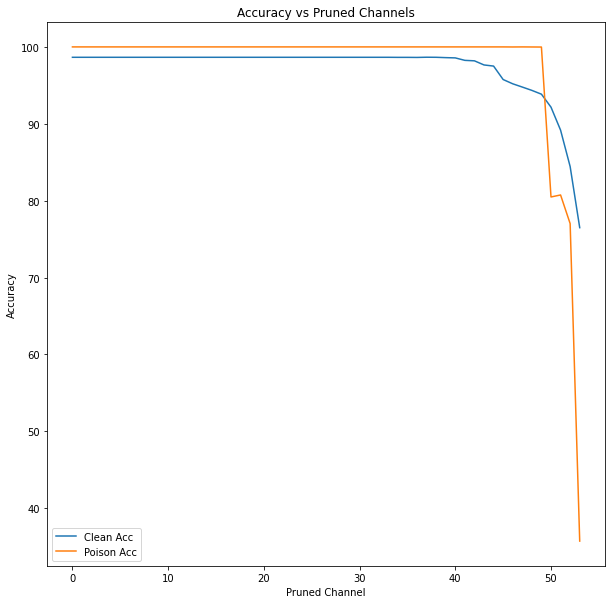

In [ ]:
num = np.arange(54)
plt.figure(figsize=(10,10))
plt.plot(num,clean_acc,label="Clean Acc")
plt.plot(num,poison_acc,label="Poison Acc")
plt.legend()
plt.xlabel('Pruned Channel')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pruned Channels')

X=2% less accuracy than original model.

In [ ]:
badnet = keras.models.load_model(bad_model)
pruned_model = pruner(badnet,"conv_3",x_clean_valid,45)
print("Number of pruned channels: ",45)
print("Pruned net on clean validation data acc: ",check_acc(pruned_model,x_clean_valid,y_clean_valid))
print("Pruned net on poison validation data acc: ",check_acc(pruned_model,x_poison_valid,y_poison_valid))

Number of pruned channels:  45
Pruned net on clean validation data acc:  95.75647354291158
Pruned net on poison validation data acc:  100.0


In [ ]:
pruned_model.save("./drive/MyDrive/Local_Lab3/pruned_net_2.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


X=4% less accuracy than original model.

In [ ]:
badnet = keras.models.load_model(bad_model)
pruned_model = pruner(badnet,"conv_3",x_clean_valid,48)
print("Number of pruned channels: ",48)
print("Pruned net on clean validation data acc: ",check_acc(pruned_model,x_clean_valid,y_clean_valid))
print("Pruned net on poison validation data acc: ",check_acc(pruned_model,x_poison_valid,y_poison_valid))

Number of pruned channels:  48
Pruned net on clean validation data acc:  94.344851476574
Pruned net on poison validation data acc:  99.9913397419243


In [ ]:
pruned_model.save("./drive/MyDrive/Local_Lab3/pruned_net_4.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


X=10% less accuracy than the original model

In [ ]:
badnet = keras.models.load_model(bad_model)
pruned_model = pruner(badnet,"conv_3",x_clean_valid,51)
print("Number of pruned channels: ",51)
print("Pruned net on clean validation data acc: ",check_acc(pruned_model,x_clean_valid,y_clean_valid))
print("Pruned net on poison validation data acc: ",check_acc(pruned_model,x_poison_valid,y_poison_valid))

Number of pruned channels:  51
Pruned net on clean validation data acc:  89.17467740538669
Pruned net on poison validation data acc:  80.73958603966398


In [ ]:
pruned_model.save("./drive/MyDrive/Local_Lab3/pruned_net_10.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


X=30% less accuracy than original model

In [ ]:
badnet = keras.models.load_model(bad_model)
pruned_model = pruner(badnet,"conv_3",x_clean_valid,53)
print("Number of pruned channels: ",53)
print("Pruned net on clean validation data acc: ",check_acc(pruned_model,x_clean_valid,y_clean_valid))
print("Pruned net on poison validation data acc: ",check_acc(pruned_model,x_poison_valid,y_poison_valid))

Number of pruned channels:  53
Pruned net on clean validation data acc:  76.48739932449988
Pruned net on poison validation data acc:  35.71490430414826


In [ ]:
print("Pruned net on clean test data acc: ",check_acc(pruned_model,x_clean_test,y_clean_test))

Pruned net on clean test data acc:  76.30553390491036


In [ ]:
pruned_model.save("./drive/MyDrive/Local_Lab3/B1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Making the good net using Badnet B and Pruned model B'

In [ ]:
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

good_model = "./drive/MyDrive/B1.h5"
B = keras.models.load_model(bad_model)
B1 = keras.models.load_model(good_model)
members = [B,B1]

In [ ]:
def compare_class(x):
  out1 = x[0]
  out2 = x[1]
  ans = tf.where(out1==out2, out2, 1283)
  return ans

The model G will be combine both the goodnet and Badnet into a single model. The argmax function and the if condition to check for backdoored input is included in the layers therefore the Evaluation script will be different than regular model. 

In [ ]:
def model_G(members):
  for i in range(len(members)):
    model = members[i]
    term = ('badnet' if i==0 else 'prunednet')
    for layer in model.layers:
      layer.trainable = False
      layer._name = term+str(i+1)+'_'+layer.name
  model_inputs = [model.input for model in members]
  out1 = keras.layers.Lambda(K.argmax, arguments={'axis': 1})(members[0].output)
  out2 = keras.layers.Lambda(K.argmax, arguments={'axis': 1})(members[1].output)
  out = keras.layers.Lambda(compare_class)([out1, out2])
  model = Model(inputs=model_inputs, outputs=out)
  plot_model(model, show_shapes=True, to_file='./drive/MyDrive/Local_Lab3/model_graph.png')
  return model

In [ ]:
G = model_G(members)

In [ ]:
G.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 badnet1_input (InputLayer)     [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 prunednet2_input (InputLayer)  [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 badnet1_conv_1 (Conv2D)        (None, 52, 44, 20)   980         ['badnet1_input[0][0]']          
                                                                                                  
 prunednet2_conv_1 (Conv2D)     (None, 52, 44, 20)   980         ['prunednet2_input[0][0]']       
                                                                                            

In [ ]:
#assigning poison class to 1283 the last class N+1
poison_class = np.ones(np.shape(y_poison_test))*1283

label = G.predict([x_clean_test,x_clean_test]) # As it has 2 subnets therefore replicating the data. 
acc_clean = np.mean(np.equal(label,y_clean_test))*100
print("Good net for Clean test data acc: ",acc_clean)

label = G.predict([x_poison_test,x_poison_test])
acc_poison = np.mean(np.equal(label,y_poison_test))*100
print("Good net for poison test data acc: ",acc_poison)

Good net for Clean test data acc:  76.16523772408418
Good net for poison test data acc:  36.26656274356976
